# Corey Nelson
## Homework 3: Due 3-Nov-2017

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

### 1. Picard Solver for p-Laplacian
Take the solver from class and add capability to change $p$ and $\epsilon$.

74

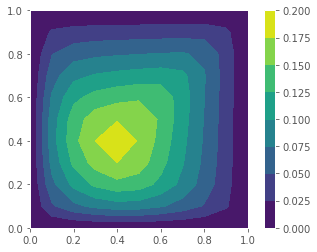

In [1]:
%matplotlib inline
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot
pyplot.style.use('ggplot')
%run ../fdtools.py

def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def nonlinear2d_PLaplace(h, x, y, epsilon, p, u, forcing, g0, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            
            #full stencil for computing the full gradients at staggered points for computing 
            stencil9 = numpy.array([idx(*pair) for pair in [(i-1,j-1),(i-1,j),(i-1,j+1),
                                                            (i,j-1),  (i,j),  (i,j+1),
                                                            (i+1,j-1),(i+1,j),(i+1,j+1)]])
            #computes the x component of the gradients at each of the staggered grid points
            gradStagX = numpy.array([[0,-2,0,0,2,0,0,0,0],
                                     [-1,-1,0,0,0,0,1,1,0],
                                     [0,0,0,0,-2,0,0,2,0],
                                     [0,-1,-1,0,0,0,0,1,1]])/(2*h)
            #computes the y component of the gradients at each of the staggered grid points
            gradStagY = numpy.array([[-1,0,1,-1,0,1,0,0,0],
                                     [0,0,0,-2,2,0,0,0,0],
                                     [0,0,0,-1,0,1,-1,0,1],
                                     [0,0,0,0,-2,2,0,0,0]])/(2*h)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            
            # Stencil to evaluate gradient at four staggered points
            grad = numpy.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            avg  = numpy.array([[1, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0],
                                [0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            ustag9 = u[stencil9]
            ugradx = gradStagX @ ustag9
            ugrady = gradStagY @ ustag9
            gradgrad = ugradx * ugradx + ugrady * ugrady
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            ustag = avg @ ustencil
            ugrad =  grad @ ustencil
            kappa = (0.5*epsilon**2 + 0.5 * gradgrad)**( (p-2)/2 ) #new kappa for P-Laplacian
            
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad) #Picard iteration
                    
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

def solve_PLaplace(h, g0, epsilon, p, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(75):
        F, J = nonlinear2d_PLaplace(h, x, y, epsilon, p, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i

p = 3
epsilon = .1
x, y, u, i = solve_PLaplace(.1, lambda x,y: 0*x, epsilon, p, dirichlet=((0,-1),(0,-1)))
pyplot.contourf(x, y, u)
pyplot.gca().set_aspect('equal') #make the figure aspect ratio right
pyplot.colorbar();
i

Looks like the Picard solver is working! Next, we will run it over a range of $p$'s to determine how fast the Picard iterations will converge holding $\epsilon = 0.1$.

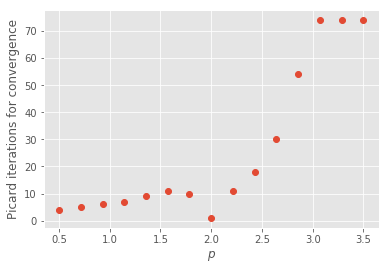

In [158]:
epsilon = 0.1
ps = numpy.linspace(0.5,3.5,15)
iters = []
for p in ps:
    _, _, _, i = solve_PLaplace(.1, lambda x,y: 0*x, epsilon, p, dirichlet=((0,-1),(0,-1)))
    iters.append(i)

pyplot.plot(ps,iters, 'o')
pyplot.xlabel("$p$")
pyplot.ylabel("Picard iterations for convergence");


After roughly $p>2.6$, the number of Picard iterations required for the solution to converge to tolerance was greater than the maximum number of allowed iterations (50)! So the number was increased to 75, and the solutions still would not converge in as many steps! For $p > 2$, the number of Picard iterations required for convergence blew up extremely fast showing that the linear approximation of the Jacobian is extremely inadequate for such a nonlinear problem.

### 2. Newton-Krylov Solver for p-Laplacian with Picard iteration preconditioner 
We will start with the newtonkrylov solver from the class notes, modifying the input parameters to just take in a system function like the nonlinear2D_PLaplace() function above. Entering the Newton iteration loop, we compute a preconditioner operator Jpreu which is a function that takes in a vector b and solves Jx = b. We use the Picard linearization of the Jacobian returned by the function above as the preconditioner. This is then passed into gmres which uses the Krylov approximation of the Jacobian to solve for du, the delta to be subtracted from our guess for u.

callPrinter() is a function which can be passed into gmres to have it print each krylov iteration norm. This allows for more verbose output.

2.33806892714e-15
Newton 0 anorm 5.09e+04 rnorm 5.65e+03
4.86713851269e-08
1.62323607912e-08
4.66867482402e-09
Newton 1 anorm 1.27e+04 rnorm 1.41e+03
3.89555893176e-07
1.3087321129e-07
3.73823734997e-08
1.09137226037e-08
5.20365044371e-09
Newton 2 anorm 3.18e+03 rnorm 3.53e+02
3.08266467321e-06
1.02404239672e-06
2.9421228322e-07
8.45768790219e-08
4.18302229894e-08
9.94568844268e-09
Newton 3 anorm 7.93e+02 rnorm 8.81e+01
2.37621672899e-05
7.5869430635e-06
2.24747116845e-06
6.23589091573e-07
3.28445787539e-07
8.01173347501e-08
1.94306792908e-08
3.78258656248e-09
Newton 4 anorm 1.97e+02 rnorm 2.19e+01
0.000171296303403
5.04128847534e-05
1.48624793507e-05
4.40019953095e-06
2.33618725704e-06
5.24890896185e-07
1.30523987116e-07
2.77289709743e-08
5.26101459391e-09
Newton 5 anorm 4.79e+01 rnorm 5.32e+00
0.00103720710913
0.000358993099985
8.41211918682e-05
3.54434402216e-05
1.07447729966e-05
2.86695938001e-06
7.58218436547e-07
1.55243323857e-07
3.02230062833e-08
6.5936433438e-09
Newton 6 anorm 

10

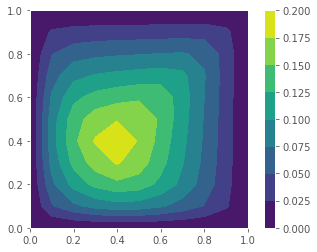

In [60]:
import scipy.sparse.linalg as splinalg

### add Jpre preconditioner matrix to act as a preconditioner for the gmres solver
def fsolve_newtonkrylov_PLaplace(sys, u0, eps=1e-8, rtol=1e-8, maxit=50, verbose=False):
    u = u0.copy().flatten()
    F,J = sys(u)

    norm0 = numpy.linalg.norm(F)
    def callPrinter(r,vb = False):
            if vb:
                print(numpy.linalg.norm(r))
                
    for i in range(maxit):
        Jprepre = splinalg.factorized(J)
        Jpreu = splinalg.LinearOperator((len(F),len(u)), matvec=Jprepre)
        
        def Ju_fd(v):
            Fuv, _ = sys(u + eps*v)
            return (Fuv - F) / eps
        Ju = splinalg.LinearOperator((len(F),len(u)), matvec=Ju_fd)
        
            
        du, info = splinalg.gmres(Ju, F, tol=1e-08, M = Jpreu, callback = lambda r:callPrinter(r,verbose))
        
        if info != 0:
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        F, J = sys(u)
        norm = numpy.linalg.norm(F)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i


h = 0.1
x, y = hgrid(h)

p = 3
epsilon = .01
u0 = 0*x

u,i = fsolve_newtonkrylov_PLaplace(lambda u: nonlinear2d_PLaplace(h, x, y, epsilon, p, u, lambda x,y: 0*x+1,
                                                                lambda x,y: 0*x, dirichlet=((0,-1),(0,-1))) , 
                                   u0, verbose = True)
u = u.reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.gca().set_aspect('equal') #make the figure aspect ratio right
pyplot.colorbar();
i



Next, we can look at the performance of the solver. Here, we make the same plot for number of Newton steps to converge at a solution. This mode of comparison is not great, as the Picard iteration solver above required a matrix vector solve at each Newton step, where that is not required here (and is replaced with the iterative Krylov method). 

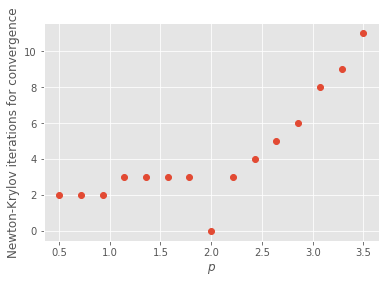

In [56]:
epsilon = 0.1
ps = numpy.linspace(0.5,3.5,15)
iters = []
for p in ps:
    u, i = fsolve_newtonkrylov_PLaplace(lambda u: nonlinear2d_PLaplace(h, x, y, epsilon, p, u, lambda x,y: 0*x+1,
                                                                lambda x,y: 0*x, dirichlet=((0,-1),(0,-1))) , 
                                   u0, verbose = False)
    iters.append(i)

pyplot.plot(ps,iters, 'o')
pyplot.xlabel("$p$")
pyplot.ylabel("Newton-Krylov iterations for convergence");

### 3. Full Newton Solve for P-Laplacian
Can a Newton's solver be truly implemented for this problem?

Yes! The way derivatives are taken in this method is with respect to the cell center variables u. As such, derivatives of derivatives are essentially reapplication of the discrete derivative operators at each cell center. We need higher derivatives in order to get at the term which we dropped in the Picard iteration, namely $\nabla\cdot\kappa( \nabla u)$. As this would be a fully Newton's method, we would expect 2nd order convergence of this method.